In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import io
from models.graph.helpers import encode
from rdkit import Chem
from molgraph import chemistry
from molgraph.chemistry import features, Featurizer, MolecularGraphEncoder
from sklearn.metrics import accuracy_score
from molgraph.models import GradientActivationMapping
from molgraph.chemistry import vis

from rdkit import Chem, rdBase
from PIL import Image
from rdkit.Chem import AllChem, Draw, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

model = tf.keras.models.load_model('./saved_models/GCNII/')

atom_encoder = Featurizer([
    features.Symbol(),
    features.TotalNumHs(),
    features.ChiralCenter(),
    features.Aromatic(),
    features.Ring(),
    features.Hetero(),
    features.HydrogenDonor(),
    features.HydrogenAcceptor(),
    features.RingSize(),
    features.GasteigerCharge()
])
bond_encoder = Featurizer([
    features.BondType(),
    features.Conjugated(),
    features.Rotatable(),
    features.Ring(),
])
encoder = MolecularGraphEncoder(atom_encoder, bond_encoder)

def get_gradcam(mol, model):
    gam_model = GradientActivationMapping(
        model,
        [i.name for i in model.layers if "conv" in i.name], # all conv layers by default
        output_activation=None,
        discard_negative_values=True)
    graph = encode(mol)
    gam = gam_model(graph)
    gam = gam[0].numpy()
    gam = gam / np.linalg.norm(gam)
    return np.where(gam > 0.3)[0].tolist()



# df = pd.DataFrame()
# smarts_files = os.listdir('./eli_lilly_smarts')
# for i in smarts_files:
#     df = pd.concat([df, pd.read_csv('./eli_lilly_smarts/' + i, sep='\t')])
# df = df.drop(columns=['min_hits_needed']).reset_index(drop=True)

covindb_df = pd.read_csv("./pwalters_filters/Covalent_bioactivity_data.csv")
covindb_df.Warhead = covindb_df.Warhead.apply(lambda x: x.lower())
warhead_list = list(covindb_df.Warhead.unique())
warhead_patten = '|'.join(covindb_df.Warhead.unique())

df = pd.read_csv("./pwalters_filters/alert_collection.csv")
df.description = df.description.apply(lambda x: x.lower())

df_test = pd.read_csv("./data/SMILES_test/test_data_all.csv")
df_test["Mol"] = df_test["SMILES"].apply(Chem.MolFromSmiles)
X = encoder(df_test["Mol"].values)
df_test["pred"] = model.predict(X)

In [3]:
df.description = df.description.apply(lambda x: x.lower())
df = df[df.description.str.contains(warhead_patten)]

/tmp/ipykernel_76900/471648110.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[df.description.str.contains(warhead_patten)]


In [6]:
i = 0
df = df[df.description.str.contains(warhead_list[i])]
print(warhead_list[i])

michael acceptor


In [7]:
COLS = [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0), (0.0, 0.0, 1.0)]

def get_hit_atoms_and_bonds(mol, smt):
  alist = []
  q = Chem.MolFromSmarts(smt)
  for match in mol.GetSubstructMatches(q):
    alist.extend(match)
  return alist


def add_colours_to_map(els, cols, col_num):
  for el in els:
    if el not in cols:
      cols[el] = []
    if COLS[col_num] not in cols[el]:
      cols[el].append(COLS[col_num])


def do_a_picture(mol, smarts, model, get_cols_only=False):
  gradcam = get_gradcam(mol, model)

  with rdDepictor.UsingCoordGen(True):
    mol = Draw.PrepareMolForDrawing(mol)

    acols = {}
    h_rads = {}
    h_lw_mult = {}

    for i, smt in enumerate(smarts):
      alist = get_hit_atoms_and_bonds(mol, smt)
      col = 0
      add_colours_to_map(alist, acols, col)

    add_colours_to_map(gradcam, acols, 1)

    if get_cols_only:
      return acols

    d = rdMolDraw2D.MolDraw2DCairo(300, 300)
    d.drawOptions().fillHighlights = False
    d.DrawMoleculeWithHighlights(mol, "", acols, {}, h_rads, h_lw_mult, -1)
    d.FinishDrawing()
    bio = io.BytesIO(d.GetDrawingText())
    return Image.open(bio)


In [8]:
import swifter
df_test = df_test.query("pred > 0.9")
smarts = df.SMARTS.values
df_test["acols"] = df_test["Mol"].swifter.apply(lambda x: do_a_picture(x, smarts, model, get_cols_only=True))

Pandas Apply: 100%|██████████| 229/229 [01:52<00:00,  2.04it/s]


In [9]:
def find_both_tags(x):
    for i in x.values():
        if len(i) > 1:
            return True
    return False
df_test["both_tags"] = df_test.acols.swifter.apply(find_both_tags)
len(df_test)

Pandas Apply: 100%|██████████| 229/229 [00:00<00:00, 303570.04it/s]


229

In [10]:
len(df_test.query("covalent == 1"))

215

In [11]:
df_final = df_test.query("both_tags == True and covalent == 1")
df_final

,SMILES,InChI,warhead_category,covalent,Mol,pred,acols,both_tags
15,[H]OC1(C([H])([H])C(=O)N([H])[H])C([H])=C(Br)C...,"InChI=1S/C8H7Br2NO3/c9-4-1-8(14,3-6(11)12)2-5(...",lactone,1,<rdkit.Chem.rdchem.Mol object at 0x7fa09cacc120>,0.988426,"{1: [(1.0, 0.0, 0.0)], 6: [(1.0, 0.0, 0.0)], 7...",True
17,[H]OC(=O)/C([H])=C(\C([H])([H])[H])C([H])([H])...,InChI=1S/C31H44O6/c1-20(16-22(3)14-15-27-12-9-...,lactone,1,<rdkit.Chem.rdchem.Mol object at 0x7fa09cacc200>,0.916504,"{4: [(1.0, 0.0, 0.0)], 3: [(1.0, 0.0, 0.0)], 1...",True
18,[H]O[C@]([H])(C([H])([H])[C@@]1([H])OC(=O)C([H...,InChI=1S/C19H32O4/c1-6-8-9-13(3)19(22-5)14(4)1...,lactone,1,<rdkit.Chem.rdchem.Mol object at 0x7fa09cacc270>,0.902995,"{9: [(1.0, 0.0, 0.0)], 8: [(1.0, 0.0, 0.0)], 7...",True
32,[H]/C(C(=O)N1C([H])([H])C([H])([H])[C@@]2([H])...,InChI=1S/C19H31N3O4S/c1-14(2)17-18-15(22(19(17...,lactam,1,<rdkit.Chem.rdchem.Mol object at 0x7fa09cacc890>,0.989165,"{19: [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0)], 0: [(...",True
40,[H]OC(=O)C1=C(/C([H])=C(\[H])C(=O)N([H])[H])C(...,"InChI=1S/C16H13N3O6S/c17-12(20)5-4-9-8-26(24,2...",lactam,1,<rdkit.Chem.rdchem.Mol object at 0x7fa09caccc10>,0.911929,"{5: [(1.0, 0.0, 0.0)], 6: [(1.0, 0.0, 0.0), (0...",True
...,...,...,...,...,...,...,...,...
410,[H]/C(=C(/F)C(=O)N([H])c1c(OC([H])([H])C([H])(...,InChI=1S/C31H31FN8O3/c1-4-42-28-16-25-23(15-26...,unsaturated,1,<rdkit.Chem.rdchem.Mol object at 0x7fa09cad6f10>,0.973918,"{0: [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0)], 1: [(1...",True
412,[H]C([H])=C([H])C(=O)N([H])c1c([H])c([H])c([H]...,InChI=1S/C23H24N4O4/c1-4-22(28)24-20-8-6-5-7-1...,unsaturated,1,<rdkit.Chem.rdchem.Mol object at 0x7fa09cad6ff0>,0.999663,"{0: [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0)], 1: [(1...",True
413,[H]C([H])=C([H])C(=O)N([H])c1c([H])c([H])c([H]...,InChI=1S/C28H29N7O2/c1-3-25(36)30-23-6-4-5-20(...,unsaturated,1,<rdkit.Chem.rdchem.Mol object at 0x7fa09cad7060>,0.999922,"{0: [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0)], 1: [(1...",True
414,[H]C([H])=C([H])C(=O)N([H])c1c([H])c([H])c([H]...,InChI=1S/C32H33ClN8O2/c1-4-28(42)36-26-10-5-6-...,unsaturated,1,<rdkit.Chem.rdchem.Mol object at 0x7fa09cad70d0>,0.998593,"{0: [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0)], 1: [(1...",True


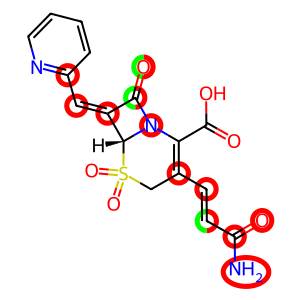

In [12]:
# red - eli lilly
# green - gradcam
# smi = 'CO[C@@H](O)C1=C(O[C@H](F)Cl)C(C#N)=C1ONNC[NH3+]'
# smi = "CN(C)CC=CC(=O)NC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC(=C(C=C3)F)Cl)OC4CCOC4"
do_a_picture(df_final.Mol.values[4], smarts, model)